In [58]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import os
import shutil
import time

In [59]:
class YOLOv8_face:
    def __init__(self, path, conf_thres=0.2, iou_thres=0.5):
        self.conf_threshold = conf_thres
        self.iou_threshold = iou_thres
        self.class_names = ['face']
        self.num_classes = len(self.class_names)

        # Initialize model
        self.net = cv2.dnn.readNet(path)
        self.input_height = 640
        self.input_width = 640
        self.reg_max = 16

        self.project = np.arange(self.reg_max)
        self.strides = (8, 16, 32)
        self.feats_hw = [(math.ceil(self.input_height / self.strides[i]), math.ceil(self.input_width / self.strides[i])) for i in range(len(self.strides))]
        self.anchors = self.make_anchors(self.feats_hw)

    def make_anchors(self, feats_hw, grid_cell_offset=0.5):
        """Generate anchors from features."""
        anchor_points = {}
        for i, stride in enumerate(self.strides):
            h,w = feats_hw[i]
            x = np.arange(0, w) + grid_cell_offset
            y = np.arange(0, h) + grid_cell_offset  
            sx, sy = np.meshgrid(x, y)
            anchor_points[stride] = np.stack((sx, sy), axis=-1).reshape(-1, 2)
        return anchor_points

    def softmax(self, x, axis=1):
        x_exp = np.exp(x)
        x_sum = np.sum(x_exp, axis=axis, keepdims=True)
        s = x_exp / x_sum
        return s
    
    def resize_image(self, srcimg, keep_ratio=True):
        top, left, newh, neww = 0, 0, self.input_width, self.input_height
        if keep_ratio and srcimg.shape[0] != srcimg.shape[1]:
            hw_scale = srcimg.shape[0] / srcimg.shape[1]
            if hw_scale > 1:
                newh, neww = self.input_height, int(self.input_width / hw_scale)
                img = cv2.resize(srcimg, (neww, newh), interpolation=cv2.INTER_AREA)
                left = int((self.input_width - neww) * 0.5)
                img = cv2.copyMakeBorder(img, 0, 0, left, self.input_width - neww - left, cv2.BORDER_CONSTANT,
                                            value=(0, 0, 0))
            else:
                newh, neww = int(self.input_height * hw_scale), self.input_width
                img = cv2.resize(srcimg, (neww, newh), interpolation=cv2.INTER_AREA)
                top = int((self.input_height - newh) * 0.5)
                img = cv2.copyMakeBorder(img, top, self.input_height - newh - top, 0, 0, cv2.BORDER_CONSTANT,
                                            value=(0, 0, 0))
        else:
            img = cv2.resize(srcimg, (self.input_width, self.input_height), interpolation=cv2.INTER_AREA)
        return img, newh, neww, top, left

    def detect(self, srcimg):
        input_img, newh, neww, padh, padw = self.resize_image(cv2.cvtColor(srcimg, cv2.COLOR_BGR2RGB))
        scale_h, scale_w = srcimg.shape[0]/newh, srcimg.shape[1]/neww
        input_img = input_img.astype(np.float32) / 255.0

        blob = cv2.dnn.blobFromImage(input_img)
        self.net.setInput(blob)
        outputs = self.net.forward(self.net.getUnconnectedOutLayersNames())
        det_bboxes, det_conf, det_classid, landmarks = self.post_process(outputs, scale_h, scale_w, padh, padw)
        return det_bboxes, det_conf, det_classid, landmarks

    def post_process(self, preds, scale_h, scale_w, padh, padw):
        bboxes, scores, landmarks = [], [], []
        for i, pred in enumerate(preds):
            stride = int(self.input_height/pred.shape[2])
            pred = pred.transpose((0, 2, 3, 1))
            
            box = pred[..., :self.reg_max * 4]
            cls = 1 / (1 + np.exp(-pred[..., self.reg_max * 4:-15])).reshape((-1,1))
            kpts = pred[..., -15:].reshape((-1,15))

            tmp = box.reshape(-1, 4, self.reg_max)
            bbox_pred = self.softmax(tmp, axis=-1)
            bbox_pred = np.dot(bbox_pred, self.project).reshape((-1,4))

            bbox = self.distance2bbox(self.anchors[stride], bbox_pred, max_shape=(self.input_height, self.input_width)) * stride
            kpts[:, 0::3] = (kpts[:, 0::3] * 2.0 + (self.anchors[stride][:, 0].reshape((-1,1)) - 0.5)) * stride
            kpts[:, 1::3] = (kpts[:, 1::3] * 2.0 + (self.anchors[stride][:, 1].reshape((-1,1)) - 0.5)) * stride
            kpts[:, 2::3] = 1 / (1+np.exp(-kpts[:, 2::3]))

            bbox -= np.array([[padw, padh, padw, padh]])
            bbox *= np.array([[scale_w, scale_h, scale_w, scale_h]])
            kpts -= np.tile(np.array([padw, padh, 0]), 5).reshape((1,15))
            kpts *= np.tile(np.array([scale_w, scale_h, 1]), 5).reshape((1,15))

            bboxes.append(bbox)
            scores.append(cls)
            landmarks.append(kpts)

        bboxes = np.concatenate(bboxes, axis=0)
        scores = np.concatenate(scores, axis=0)
        landmarks = np.concatenate(landmarks, axis=0)
    
        bboxes_wh = bboxes.copy()
        bboxes_wh[:, 2:4] = bboxes[:, 2:4] - bboxes[:, 0:2]
        classIds = np.argmax(scores, axis=1)
        confidences = np.max(scores, axis=1)
        
        mask = confidences>self.conf_threshold
        bboxes_wh = bboxes_wh[mask]
        confidences = confidences[mask]
        classIds = classIds[mask]
        landmarks = landmarks[mask]
        
        indices = cv2.dnn.NMSBoxes(bboxes_wh.tolist(), confidences.tolist(), self.conf_threshold,
                                    self.iou_threshold)
                                    
        if len(indices) > 0:
            mlvl_bboxes = bboxes_wh[indices]
            confidences = confidences[indices]
            classIds = classIds[indices]
            landmarks = landmarks[indices]
            return mlvl_bboxes, confidences, classIds, landmarks
        else:
            return np.array([]), np.array([]), np.array([]), np.array([])

    def distance2bbox(self, points, distance, max_shape=None):
        x1 = points[:, 0] - distance[:, 0]
        y1 = points[:, 1] - distance[:, 1]
        x2 = points[:, 0] + distance[:, 2]
        y2 = points[:, 1] + distance[:, 3]
        if max_shape is not None:
            x1 = np.clip(x1, 0, max_shape[1])
            y1 = np.clip(y1, 0, max_shape[0])
            x2 = np.clip(x2, 0, max_shape[1])
            y2 = np.clip(y2, 0, max_shape[0])
        return np.stack([x1, y1, x2, y2], axis=-1)
    
    def draw_detections(self, image, boxes, scores, kpts):
        for box, score, kp in zip(boxes, scores, kpts):
            x, y, w, h = box.astype(int)
            # Draw rectangle
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), thickness=2)
            # cv2.putText(image, "face:"+str(round(score,2)), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), thickness=2)
            for i in range(5):
                cv2.circle(image, (int(kp[i * 3]), int(kp[i * 3 + 1])), 4, (0, 255, 0), thickness=-1)
        return image

In [60]:
# Initialize YOLOv8_face object detector
YOLOv8_face_detector = YOLOv8_face(r"..\utils\yolov8n-face.onnx", conf_thres=0.3, iou_thres=0.3)

In [61]:
def toYolo(x, y, x1, y1, image_width, image_height) :
    # Hitung pusat kotak
    cx = (x + x1) / 2.0
    cy = (y + y1) / 2.0

    # Hitung lebar dan tinggi
    w = x1 - x
    h = y1 - y

    # Normalisasi koordinat ke dalam rentang 0-1
    cx /= image_width
    cy /= image_height
    w /= image_width
    h /= image_height

    return cx, cy, w, h

def copy(src, dst):
    if os.path.isdir(dst):
        dst = os.path.join(dst, os.path.basename(src))
    shutil.copyfile(src, dst)

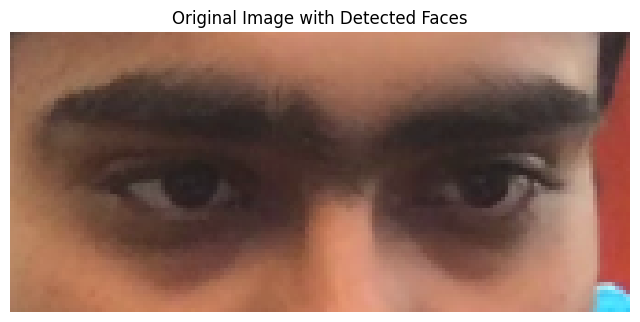

In [57]:
img = cv2.cvtColor(cv2.imread('../../sample/ZB0001.png'), cv2.COLOR_BGR2RGB)

boxes, scores, classids, kpts = YOLOv8_face_detector.detect(img)
image_height, image_width, _ = img.shape

img_with_dets = img.copy()
min_conf = 0.2

if scores[0] >= min_conf:
    coor = kpts[0]

    x_eyes, y_eyes, w_eyes, h_eyes = int(coor[0]) - 40, int(coor[1]) - 40, int(coor[3]) + 40, int(coor[4]) + 40

    normalized_cx_eyes, normalized_cy_eyes, normalized_bw_eyes, normalized_bh_eyes = toYolo(x_eyes, y_eyes, w_eyes, h_eyes, image_width, image_height)

    x, y, w, h = float(normalized_cx_eyes), float(normalized_cy_eyes), float(normalized_bw_eyes), float(normalized_bh_eyes)

    # Hitung koordinat sudut kiri atas dan kanan bawah bounding box
    x1 = int((x - w / 2) * img.shape[1])
    y1 = int((y - h / 2) * img.shape[0])
    x2 = int((x + w / 2) * img.shape[1])
    y2 = int((y + h / 2) * img.shape[0])

    roi = img[y1:y2, x1:x2]
    
    plt.figure(figsize=(8, 6))
    plt.imshow(roi)
    plt.title('Original Image with Detected Faces')
    plt.axis('off')
    plt.show()

In [ ]:
## Eksperimen 1

error = 0

for path, subdirs, files in os.walk('../../dataset/Non Drowsy'):
    for name in tqdm(files) :
        try :
            path_parts = path.split('/')
            label = path_parts[-1]

            # Load the input image
            img_path = os.path.join(path, name)
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

            boxes, scores, classids, kpts = YOLOv8_face_detector.detect(img)
            image_height, image_width, _ = img.shape

            img_with_dets = img.copy()
            min_conf = 0.1

            if scores[0] >= min_conf:
                coor = kpts[0]
                
                x_eyes, y_eyes, w_eyes, h_eyes = int(coor[0]) - 25, int(coor[1]) - 25, int(coor[3]) + 25, int(coor[4]) + 25
                x_mouth, y_mouth, w_mouth, h_mouth = int(coor[9]) - 5, int(coor[10]) - 20, int(coor[12]) + 5, int(coor[13]) + 20
                x_r_eye, y_r_eye, w_r_eye, h_r_eye = int(coor[0]) - 25, int(coor[1]) - 25, int(coor[0]) + 35, int(coor[1]) + 35
                x_l_eye, y_l_eye, w_l_eye, h_l_eye = int(coor[3]) - 35, int(coor[4]) - 35, int(coor[3]) + 25, int(coor[4]) + 25
                
                normalized_cx_eyes, normalized_cy_eyes, normalized_bw_eyes, normalized_bh_eyes = toYolo(x_eyes, y_eyes, w_eyes, h_eyes, image_width, image_height)
                normalized_cx_mouth, normalized_cy_mouth, normalized_bw_mouth, normalized_bh_mouth = toYolo(x_mouth, y_mouth, w_mouth, h_mouth, image_width, image_height)
                normalized_cx_r_eye, normalized_cy_r_eye, normalized_bw_r_eye, normalized_bh_r_eye = toYolo(x_r_eye, y_r_eye, w_r_eye, h_r_eye, image_width, image_height)
                normalized_cx_l_eye, normalized_cy_l_eye, normalized_bw_l_eye, normalized_bh_l_eye = toYolo(x_l_eye, y_l_eye, w_l_eye, h_l_eye, image_width, image_height)

                # Convert to YOLO format line
                yolo_line = f"""1 {normalized_cx_mouth:.6f} {normalized_cy_mouth:.6f} {normalized_bw_mouth:.6f} {normalized_bh_mouth:.6f}
2 {normalized_cx_r_eye:.6f} {normalized_cy_r_eye:.6f} {normalized_bw_r_eye:.6f} {normalized_bh_r_eye:.6f}
3 {normalized_cx_l_eye:.6f} {normalized_cy_l_eye:.6f} {normalized_bw_l_eye:.6f} {normalized_bh_l_eye:.6f}
4 {normalized_cx_eyes:.6f} {normalized_cy_eyes:.6f} {normalized_bw_eyes:.6f} {normalized_bh_eyes:.6f}"""

                labels_folder = f"dataset sinta yolo-face/labels/{label}"
                images_folder = f"dataset sinta yolo-face/images/{label}"

                os.makedirs(labels_folder, exist_ok=True)
                os.makedirs(images_folder, exist_ok=True)

                copy(os.path.join(path, name), images_folder)
                with open(os.path.join(labels_folder, f'{name[:-4]}.txt'), 'w') as file:
                    file.write(yolo_line)

        except Exception as e :
            error += 1

print(error)

In [62]:
## Eksperimen 2

error = 0

start = time.time()

for path, subdirs, files in os.walk('../../dataset'):
    for name in tqdm(files) :
        try :
            path_parts = path.split('/')
            label = path_parts[-1]

            # Load the input image
            img_path = os.path.join(path, name)
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

            boxes, scores, classids, kpts = YOLOv8_face_detector.detect(img)
            image_height, image_width, _ = img.shape

            img_with_dets = img.copy()
            min_conf = 0.2

            if scores[0] >= min_conf:
                coor = kpts[0]
                
                x_eyes, y_eyes, w_eyes, h_eyes = int(coor[0]) - 40, int(coor[1]) - 40, int(coor[3]) + 40, int(coor[4]) + 40
                
                normalized_cx_eyes, normalized_cy_eyes, normalized_bw_eyes, normalized_bh_eyes = toYolo(x_eyes, y_eyes, w_eyes, h_eyes, image_width, image_height)
                
                # Convert to YOLO format line
                yolo_line = f"""4 {normalized_cx_eyes:.6f} {normalized_cy_eyes:.6f} {normalized_bw_eyes:.6f} {normalized_bh_eyes:.6f}"""

                labels_folder = f"../dataset sinta yolo-face2/labels/{label}"
                images_folder = f"../dataset sinta yolo-face2/images/{label}"

                os.makedirs(labels_folder, exist_ok=True)
                os.makedirs(images_folder, exist_ok=True)

                copy(os.path.join(path, name), images_folder)
                with open(os.path.join(labels_folder, f'{name[:-4]}.txt'), 'w') as file:
                    file.write(yolo_line)

        except Exception as e :
            error += 1

end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

print(error)

0it [00:00, ?it/s]
  0%|          | 0/22348 [00:00<?, ?it/s]

  9%|▉         | 2096/22348 [10:33<2:26:34,  2.30it/s]C:\Users\PLWEP\AppData\Local\Temp\ipykernel_8728\2462096230.py:74: RuntimeWarning: overflow encountered in exp
  cls = 1 / (1 + np.exp(-pred[..., self.reg_max * 4:-15])).reshape((-1,1))
100%|██████████| 19445/19445 [1:07:01<00:00,  4.84it/s]

02:34:49.45
5479
